In [59]:
import cv2
from mpl_toolkits.mplot3d import Axes3D
import logging
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
from math import pow , sqrt, atan2
import math
import pywt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(color_codes=True)
from sklearn.manifold import LocallyLinearEmbedding
from sklearn import manifold, datasets
from scipy.signal import argrelextrema
from scipy.spatial.distance import pdist
from scipy.stats.mstats import pearsonr, spearmanr
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn import metrics
Axes3D


mpl_toolkits.mplot3d.axes3d.Axes3D

# Functions

In [31]:
# Calculate the Residual variance with original dataset and LLE or HLLE dataset

def res_var(X_origi, X_transfo):
    #X_origi   = original dataset
    #X_transfo = modified dataset
    
    #pairwise euclidean distance
    Dx = pdist(X_origi, 'euclidean')
    Dy = pdist(X_transfo, 'euclidean')

    #Pearson correlation
    pxy, _ = pearsonr(Dx, Dy)

    #residual variance
    res_var = 1 - pxy**2
    
    return res_var
# Calculate the Spearman's rho coeff with original dataset and LLE or HLLE dataset
def SpearsmansRho (X_origi, X_transfo):
    #X_origi   = original dataset
    #X_transfo = modified dataset
    
    nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X_origi)
    dist, _ = nbrs.kneighbors(X_origi)

    nbrs2 = NearestNeighbors(n_neighbors=15, algorithm='ball_tree').fit(X_transfo)
    dist2, _ = nbrs2.kneighbors(X_transfo)

    dist  = np.delete(dist, 0, 1)
    dist2 = np.delete(dist2, 0, 1)
    coef, p = spearmanr(dist, dist2,axis=None)
    return  np.mean(coef)

# find best number of neighbor
def num_neigh(Data,dim, meth,plot="ON"):
    SP_Rho_vect       = []
    Residual_var_vect = []
    N_Neigh_Max       = 35
    NCOMP             = dim
    if meth == "standard":
        nmin   = NCOMP+1
        Vect_N = np.arange(nmin,N_Neigh_Max,1)
    if meth == "hessian":
        nmin   = round(NCOMP*(NCOMP+3)/2)+2
        Vect_N = np.arange( nmin,N_Neigh_Max,1)
    Tot_Err     = []
    for j in range(nmin):
        SP_Rho_vect.append(0)
        Residual_var_vect.append(0)
    for i in Vect_N:
        DataTransfo, err = manifold.locally_linear_embedding(Data, n_neighbors=i,n_components=NCOMP,method = meth)
        Tot_Err.append(err)
        SP_Rho_vect.append(SpearsmansRho(DataTransfo,Data))
        Residual_var_vect.append(res_var(Data,DataTransfo))

    Tot_err = np.array(Tot_Err)
    maxval_SP =max(SP_Rho_vect[nmin:]) 
    indicemax_SP = SP_Rho_vect.index(maxval_SP)
    minval_SP =min(SP_Rho_vect[nmin:]) 
    indicemin_SP = SP_Rho_vect.index(minval_SP)
    combin = np.array(SP_Rho_vect) * np.array(Residual_var_vect)
    max_combi =max(combin[nmin:])
    min_combi =min(combin[nmin:])

    best_N = np.where(combin == max(combin[nmin:]))
    best_N=best_N[0][0]
    worst_N = np.where(combin == min(combin[nmin:]))
    worst_N=worst_N[0][0]
    if plot == "ON":
        plt.figure(meth,figsize=(8, 8))
        plt.title( meth)
        plt.xlabel("Number of Neighbor")
        plt.ylabel("Values")
        plt.plot (SP_Rho_vect,color ="red",label="Spearman's Rho")
        plt.plot (Residual_var_vect,color ="yellow",label="residual variance")
        plt.plot(combin,color ="orange",label="Spearman's Rho* residual variance")

        plt.plot (best_N,max_combi,"go",color ="green",label="max Spearman's Rho*residual variance")
        plt.plot (worst_N,min_combi,"go",color ="red",label="min Spearman's Rho*residual variance")

        plt.legend(loc ="lower left")
        plt.text(20,0,"worst K = "+ str(worst_N) +" and best K = " + str(best_N))
        
    return best_N,worst_N,Residual_var_vect,SP_Rho_vect




# TOY's Data set


In this section we will play with a swiss roll data set to understand the characteristic of LLE and HLLE.
1) we will compute the best number of neighbor with a swiss data set without noise.

2) we will do the same with medium noise.

3) we will compare the best number of neighbor in regard of the number of datapoiint.


To compute the best Num neigbhboor, 
we take the max of the residual variance multiply to the spearman's rho. Spearman's rho is a way to see if the projection keep well his geometry.
and the residual variance. 

## Toy data without noise

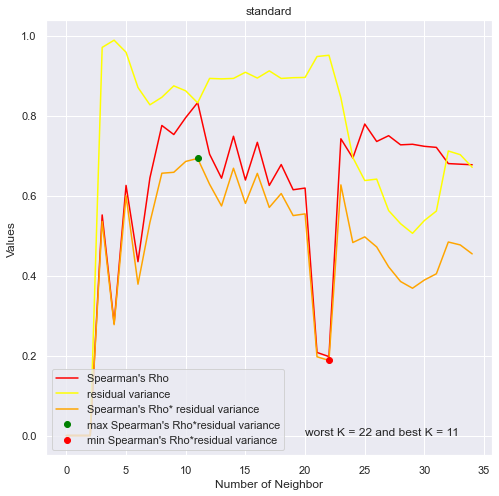

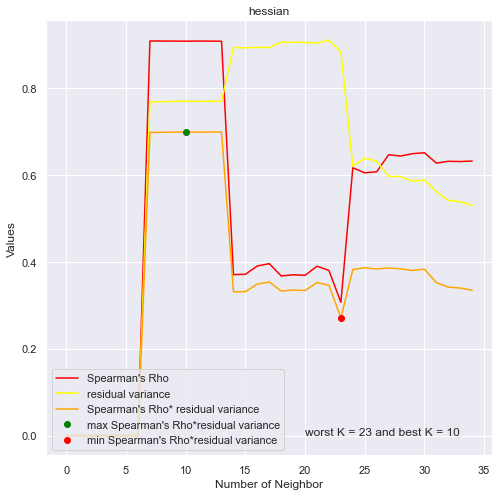

In [32]:
# the swiss roll
Dataset_swissroll, color = datasets.make_swiss_roll(n_samples=1000,noise = 0.0)
Best_N_LLE,Worst_N_LLE,_,_ = num_neigh(Dataset_swissroll,2, "standard")
Best_N_HLLE,Worst_N_HLLE,_,_ = num_neigh(Dataset_swissroll,2, "hessian")


Best projection LLE
Done. Reconstruction error: 2.61052e-07
Number of neighbor: 13
worst projection LLE 
Done. Reconstruction error: 9.99899e-10
Number of neighbor: 5


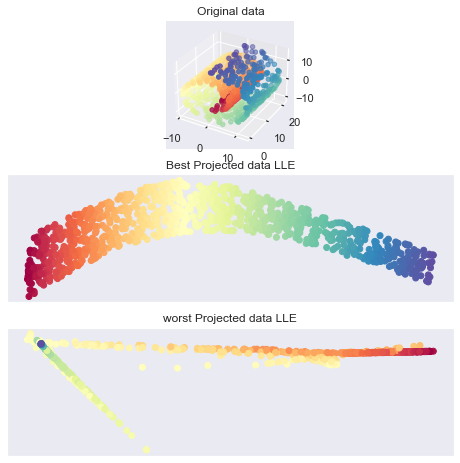

In [13]:
# LLE 

print("Best projection LLE")
X_B_LLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Best_N_LLE,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_LLE)
print("worst projection LLE ")
X_W_LLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Worst_N_LLE,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_LLE)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B_LLE[:, 0], X_B_LLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE')

ax = fig.add_subplot(313)
ax.scatter(X_W_LLE[:, 0], X_W_LLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data LLE')
plt.show()

Best projection HLLE
Done. Reconstruction error: 4.60183e-07
Number of neighbor: 7
worst projection HLLE
Done. Reconstruction error: 0.00299267
Number of neighbor: 22


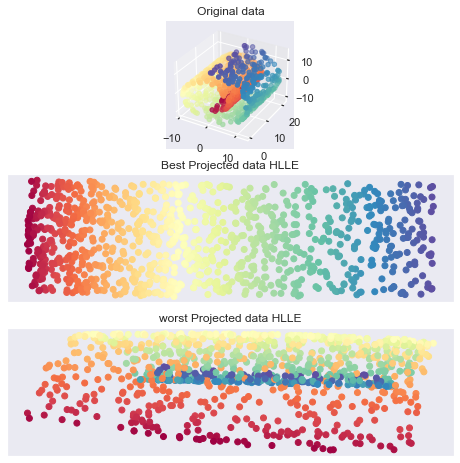

In [14]:
# HLLE 

print("Best projection HLLE")
X_B_HLLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Best_N_HLLE,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_HLLE)
print("worst projection HLLE" )
X_W_HLLE, err = manifold.locally_linear_embedding(Dataset_swissroll, n_neighbors=Worst_N_HLLE,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_HLLE)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll[:, 0], Dataset_swissroll[:, 1], Dataset_swissroll[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B_HLLE[:, 0], X_B_HLLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE')

ax = fig.add_subplot(313)
ax.scatter(X_W_HLLE[:, 0], X_W_HLLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data HLLE')
plt.show()

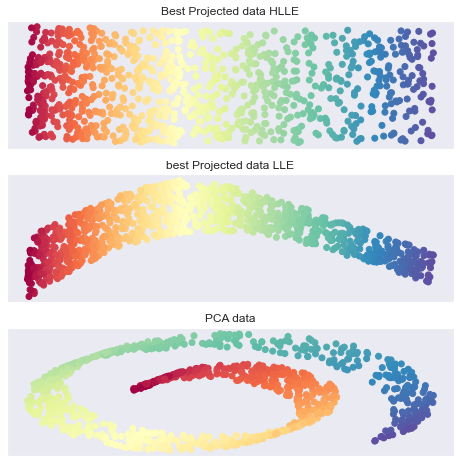

In [15]:

# LLE HLLE and PCA 


pca = PCA(n_components=2)
X_PCA = pca.fit_transform(Dataset_swissroll)

fig = plt.figure(figsize=(8, 8))


ax = fig.add_subplot(311)
ax.scatter(X_B_HLLE[:, 0], X_B_HLLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE')

ax = fig.add_subplot(312)
ax.scatter(X_B_LLE[:, 0], X_B_LLE[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('best Projected data LLE')

ax = fig.add_subplot(313)
ax.scatter(X_PCA[:, 0], X_PCA[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('PCA data')
plt.show()


## Toy data with noise

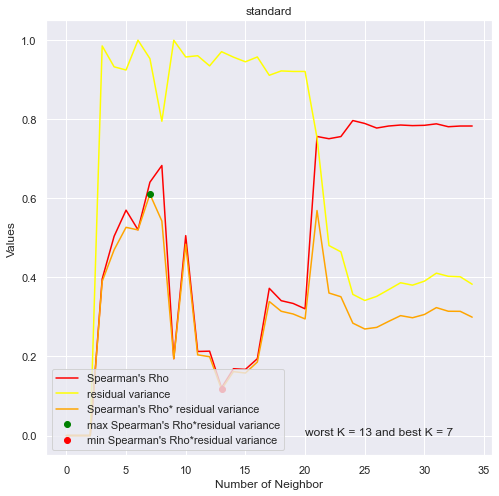

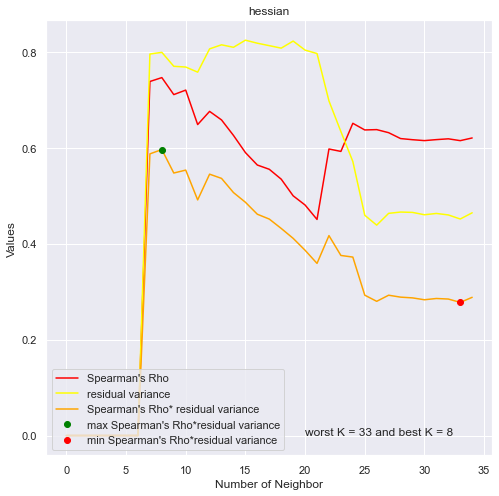

In [26]:
# the swiss roll
Dataset_swissroll_noisy, color = datasets.make_swiss_roll(n_samples=1000,noise = 0.5)
Best_N_LLE_noisy,Worst_N_LLE_noisy,_,_ = num_neigh(Dataset_swissroll_noisy,2, "standard")
Best_N_HLLE_noisy,Worst_N_HLLE_noisy,_,_ = num_neigh(Dataset_swissroll_noisy,2, "hessian")
#avec le bruit la hessian marche pas parfois, du coup faut juste reload

Best projection LLE
Done. Reconstruction error: 1.93319e-09
Number of neighbor: 7
worst projection LLE 
Done. Reconstruction error: 6.99436e-08
Number of neighbor: 13


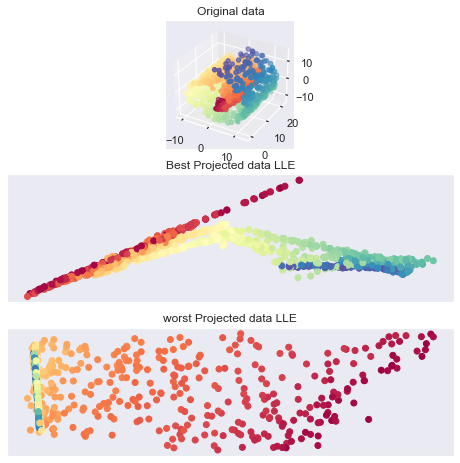

In [27]:
# LLE 

print("Best projection LLE")
X_B_LLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=Best_N_LLE_noisy,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_LLE_noisy)
print("worst projection LLE ")
X_W_LLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=Worst_N_LLE_noisy,n_components=2)
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_LLE_noisy)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll_noisy[:, 0], Dataset_swissroll_noisy[:, 1], Dataset_swissroll_noisy[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B_LLE_noisy[:, 0], X_B_LLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data LLE')

ax = fig.add_subplot(313)
ax.scatter(X_W_LLE_noisy[:, 0], X_W_LLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data LLE')
plt.show()

Best projection HLLE
Done. Reconstruction error: 0.000232993
Number of neighbor: 8
worst projection HLLE
Done. Reconstruction error: 0.0738788
Number of neighbor: 33


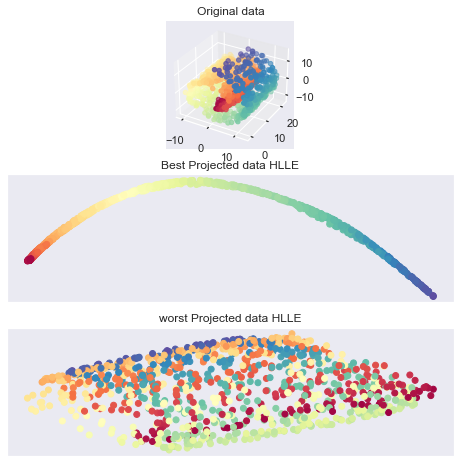

In [28]:
# HLLE 

print("Best projection HLLE")
X_B_HLLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=Best_N_HLLE_noisy,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Best_N_HLLE_noisy)
print("worst projection HLLE" )
X_W_HLLE_noisy, err = manifold.locally_linear_embedding(Dataset_swissroll_noisy, n_neighbors=Worst_N_HLLE_noisy,n_components=2,method = "hessian")
print("Done. Reconstruction error: %g" % err)
print("Number of neighbor: %g" % Worst_N_HLLE_noisy)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(311, projection='3d')
ax.scatter(Dataset_swissroll_noisy[:, 0], Dataset_swissroll_noisy[:, 1], Dataset_swissroll_noisy[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

ax = fig.add_subplot(312)
ax.scatter(X_B_HLLE_noisy[:, 0], X_B_HLLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE')

ax = fig.add_subplot(313)
ax.scatter(X_W_HLLE_noisy[:, 0], X_W_HLLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('worst Projected data HLLE')
plt.show()

si noisy LLE marche pas, mais HLLE oui!

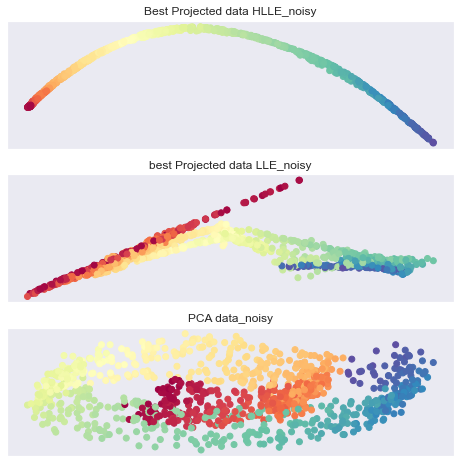

In [29]:

# LLE HLLE and PCA 



pca = PCA(n_components=2)
X_PCA_noisy = pca.fit_transform(Dataset_swissroll_noisy)

fig = plt.figure(figsize=(8, 8))


ax = fig.add_subplot(311)
ax.scatter(X_B_HLLE_noisy[:, 0], X_B_HLLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Best Projected data HLLE_noisy')

ax = fig.add_subplot(312)
ax.scatter(X_B_LLE_noisy[:, 0], X_B_LLE_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('best Projected data LLE_noisy')

ax = fig.add_subplot(313)
ax.scatter(X_PCA_noisy[:, 0], X_PCA_noisy[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('PCA data_noisy')
plt.show()

## Various number of datapoint without noise

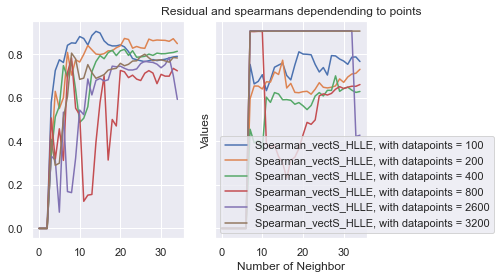

In [54]:
# the swiss roll

Vect_point = [100,200,400,800,2600,3200]

Spearman_vectS_LLE = []
Residual_vectS_LLE = []
Spearman_vectS_HLLE = []
Residual_vectS_HLLE = []
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plt.title( "Residual and spearmans dependending to points")
plt.xlabel("Number of Neighbor")
plt.ylabel("Values")


for i in Vect_point:
    Dataset_swissroll_point, color = datasets.make_swiss_roll(n_samples=i,noise = 0.0)
    _,_,Residual_vectS_LLE,Spearman_vectS_LLE = num_neigh(Dataset_swissroll_point,2, "standard","OFF")
    _,_,Residual_vectS_HLLE,Spearman_vectS_HLLE = num_neigh(Dataset_swissroll_point,2, "hessian","OFF")
    #ax1.plot(Spearman_vectS_LLE[:, 0], Spearman_vectS_LLE[:, 1], c=color, cmap=plt.cm.Spectral)
    #ax2.plot(Spearman_vectS_HLLE[:, 0], Spearman_vectS_HLLE[:, 1], c=color, cmap=plt.cm.Spectral)

    ax1.plot (Spearman_vectS_LLE,label="Spearman_vectS_LLE, with datapoints = "+ str(i))
    #plt.plot (Residual_vectS_LLE,label="Residual_vectS_LLE, with datapoints = "+ str(i))
    ax2.plot (Spearman_vectS_HLLE,label="Spearman_vectS_HLLE, with datapoints = "+ str(i))
    #plt.plot (Residual_vectS_HLLE,label="Residual_vectS_HLLE, with datapoints = "+ str(i))

ax1.plt.legend(loc ="lower left")
ax2.plt.legend(loc ="lower left")

plt.show()


In [ ]:
# the swiss roll

Vect_point = [100,500,1000,1500,2500]

Spearman_vectS_LLE = []
Residual_vectS_LLE = []
Spearman_vectS_HLLE = []
Residual_vectS_HLLE = []
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 6), sharey=True)
plt.title( "spearmans dependending to points for LLE and HLLE")
plt.xlabel("Number of Neighbor")
plt.ylabel("Values")


for i in Vect_point:
    Dataset_swissroll_point, color = datasets.make_swiss_roll(n_samples=i,noise = 0.0)
    _,_,Residual_vectS_LLE,Spearman_vectS_LLE = num_neigh(Dataset_swissroll_point,2, "standard","OFF")
    _,_,Residual_vectS_HLLE,Spearman_vectS_HLLE = num_neigh(Dataset_swissroll_point,2, "hessian","OFF")

    ax1.plot (Spearman_vectS_LLE,label="Spearman_vectS_LLE, with datapoints = "+ str(i))
    ax2.plot (Spearman_vectS_HLLE,label="Spearman_vectS_HLLE, with datapoints = "+ str(i))

ax1.legend(loc ="lower left")
ax2.legend(loc ="lower left")
plt.show()


# OUR dataset

In [60]:
# reading csv files
data =  pd.read_csv('../semeion.data',header=None, sep=" ")
data = data.drop(columns=[266])
# 256 first columns is pixel and the last 10 is to say which number is it.
# 1593 data
data.shape


FileNotFoundError: [Errno 2] No such file or directory: '../semeion.data'

In [57]:
# keep just the pixel for visualization
images = data.truncate(before="0", after="255", axis="columns")
image =[0]*1593
image_reshape =[0]*1593
for i in range (0,1592):
    image[i] = np.array(images.iloc[i])
    image_reshape[i] = np.reshape(image[i],(16,16))

NameError: name 'data' is not defined

NameError: name 'image_reshape' is not defined

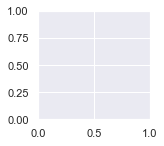

In [58]:
#plot each image
for i in range (0,1592):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(image_reshape[i], cmap=plt.cm.gray)
    plt.show()

In [ ]:
names = 